## Identifying Duplicate Questions
Quora Question Pairs dataset! Here, our goal is to identify which questions asked on Quora, a website, are duplicates of questions that have already been asked. Our focus for this assignment will be to learn how to create features from a textual data. Using some inherent knowledge of text and certain feature generation techniques will be used.

The assignment has the following parts :
1. Import libraries
2. Read training dataset
3. Description of Columns
4. Data Visualisation
5. Selecting our Model Performance Criteria
6. Read test dataset
7. Text analysis
8. Semantic Analysis
9. Initial Feature Generation
10. Split train/ test dataset using the features we created above
11. Use XGBoost to predict if the questions are duplicate
12. Visualize Boosting Trees
13. Visualize Feature Importance

### 1. Import libraries

In [2]:
# call the below to plot the tree generated by XGBoost
# !pip install graphviz

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pal = sns.color_palette()

### 2. Read training dataset

In [5]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### 3. Description of Columns:
- id: Looks like a simple rowID
- qid{1, 2}: The unique ID of each question in the pair
- question{1, 2}: The actual textual contents of the questions.
- is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

##### Source : https://www.kaggle.com/c/quora-question-pairs/data

### 4. Data Visualisation
To understand the distribution of the different variables

We will use the pandas's hist() method to plot a histogram

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



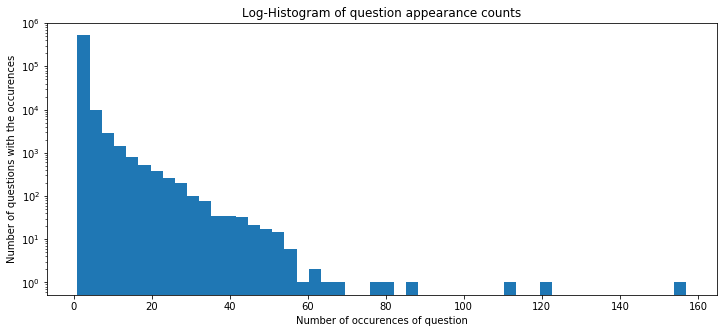

In [10]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions with the occurences')
print()

### Conclusion
Most questions only appear a few times, with very few questions appearing several times (and a few questions appearing many times). Few questions appear more than 100 times, can be considered an outlier. In most cases we cases we can remove it, however in this project we keep it.


### 5. Selecting our Model Performance Criteria

In [11]:
# After a visualizing the dataset. 
# We can see that we have a 37% positive class in this dataset using the LogLoss metric, 
# and LogLoss looks at the actual predicts is logical 

# Logarithmic loss (related to cross-entropy) measures the performance of a classification model 
# where the prediction input is a probability value between 0 and 1. The goal of our machine learning models 
# is to minimize this value. A perfect model would have a log loss of 0. 
# Log loss increases as the predicted probability diverges from the actual label. 
# So predicting a probability of .012 when the actual observation label is 1 would be bad and 
# result in a high log loss.

from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv('test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()

Predicted score: 0.6585273839844354


,test_id,is_duplicate
0,0,0.369198
1,1,0.369198
2,2,0.369198
3,3,0.369198
4,4,0.369198


### 6. Read test dataset

In [12]:
df_test = pd.read_csv('test.csv')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [13]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 2345796


### 7. Text analysis
Histograms to understand what we're looking at. 
Most analysis here will be only on the training set.

mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.62 max-train 1169.00 max-test 1176.00


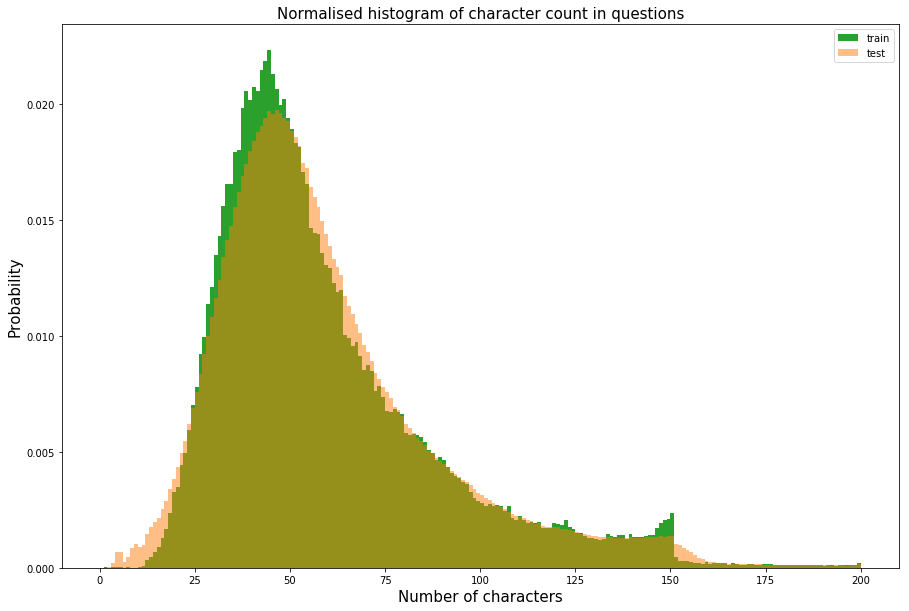

In [14]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


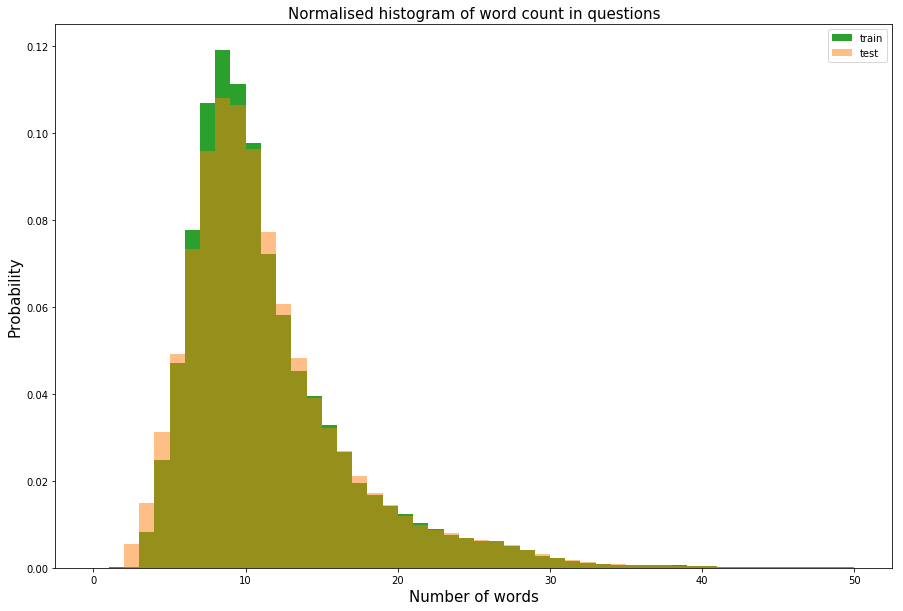

In [15]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

(-0.5, 1439.5, 1079.5, -0.5)

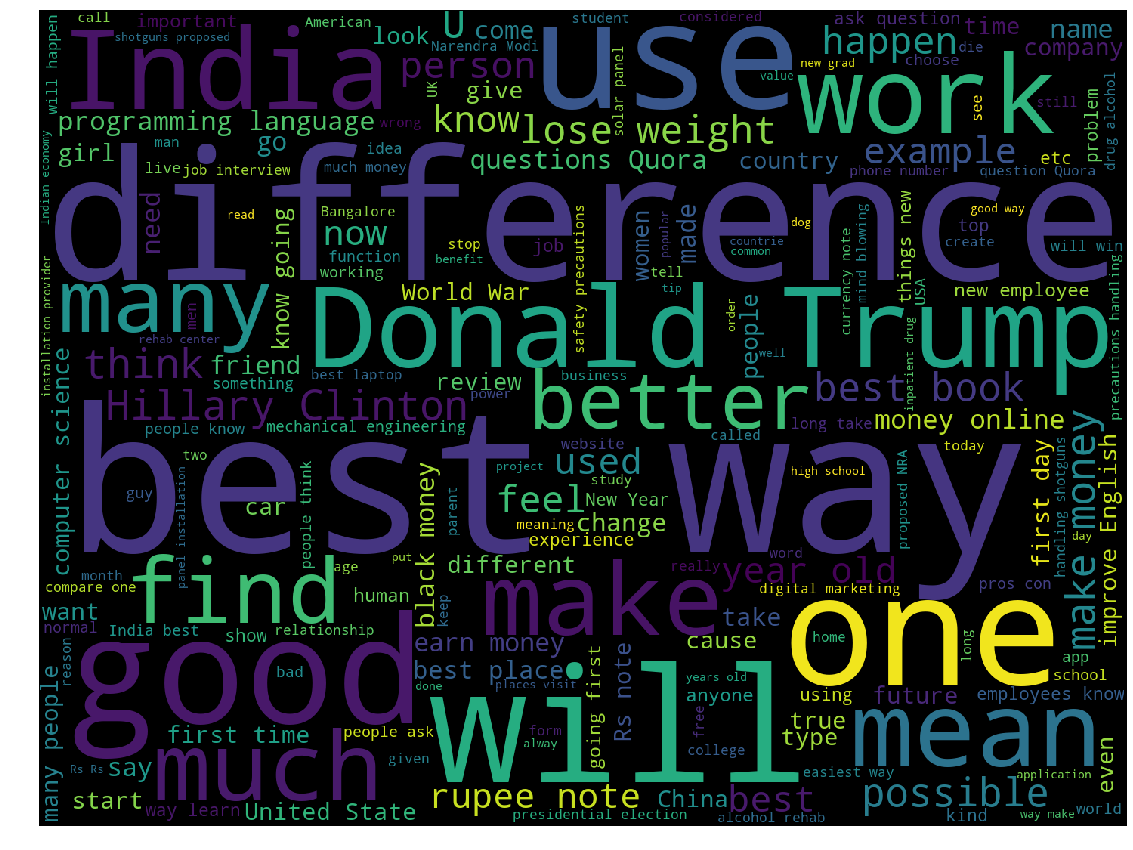

In [40]:
# A wordcloud to see the most common words

from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

Word clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.


As you can see, words like “best,” “way,” “difference” and “Trump” stand out since they were used more frequently in the original text.

Hence we can explore the words that are common in both the questions

### Recap : 
Up until now we have visualised the following :
1. Number of characters and their frequencies
2. Number of words and their frequencies
3. A wordcloud to see the most common words

### 8. Semantic Analysis
Look at usage of different punctuation in questions

In [18]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))


Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


### 9. Initial Feature Generation
Looking at how powerful some features are. Start with the word share feature from the benchmark model.

Stopwords - words which are filtered out before or after processing of natural language data (text).

Text(0, 0.5, 'Frequency')

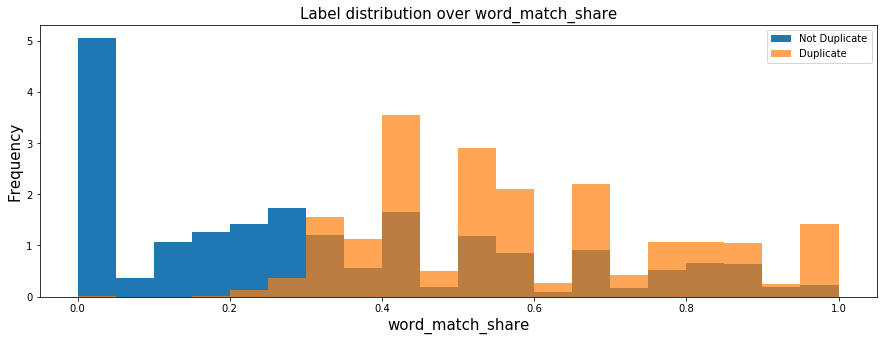

In [21]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

# Creating a function to call to create a word_match share feature
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    # Fraction of words that are common
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

# plot the word_match_share vs the number of questions for each share

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)

# Calling the hist function on the dataframe to create a histogram
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

### TF-IDF
Using TF-IDF (term-frequency-inverse-document-frequency). Weigh the terms by how uncommon they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.

Reference - https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [22]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [23]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [24]:
# Creating a function to call create a tfidf_train_word_match share feature

def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    # Fraction of words that are common
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

Text(0, 0.5, 'Frequency')

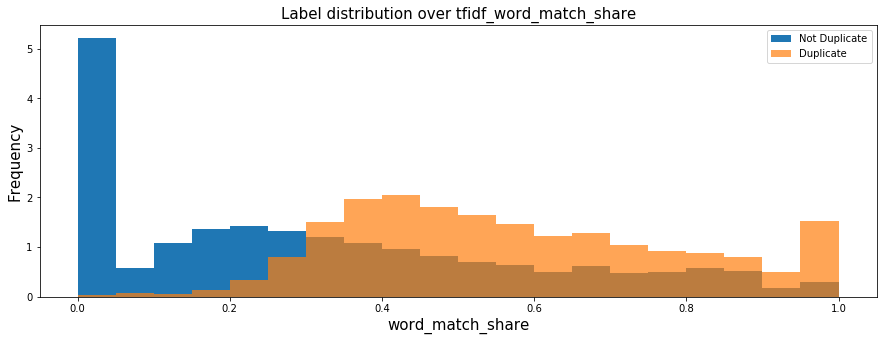

In [25]:
# plot the tfidf_train_word_match vs the number of questions for each share using the 'hist' function
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)

# Calling the hist function on the dataframe to create a histogram
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

In [24]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7804327049353577
   TFIDF AUC: 0.7704802292218704


The TF-IDF actually got worse in terms of overall AUC. (I am using the AUC metric since it is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.

Also, TF-IDF word match share is a more robust feature as compared to a naive word_match hence we use the both the features. We will now ompare the performance of both these features using a model.

Combining these features and use it to make a prediction. For this, we will use XGBoost to make a classification model.

### 10. Split train/ test dataset using the features we created above

In [26]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

In [28]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# recode the predicted results. Based on logistic regression, if predicted possibility > 0.5 
# then we code it as 1
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [29]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 11. Use XGBoost to predict if the questions are duplicate

In [28]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[19:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.683201	valid-logloss:0.683252
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[19:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:07] src/

[19:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[70]	train-logloss:0.416379	valid-logloss:0.418048
[19:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:20] src/tree/updater_prune.cc:74: tree pruning

[19:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[19:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[140]	train-logloss:0.374091	valid-logloss:0.376139
[19:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:33] src/tree/updater_prune.cc:74: tree prunin

[19:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[210]	train-logloss:0.365419	valid-logloss:0.367556
[19:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:32:46] src/tree/updater_prune.cc:74: tree prunin

[19:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[280]	train-logloss:0.363117	valid-logloss:0.365328
[19:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:32:59] src/tree/updater_prune.cc:74: tree prunin

[19:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[350]	train-logloss:0.362057	valid-logloss:0.364331
[19:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:33:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:33:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:33:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:33:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:33:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:33:11] src/tree/updater_prune.cc:74: tree prunin

In [29]:
# make new predictons on the test data

d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

### 12. Visualize Boosting Trees
One can also visualize individual trees from the fully boosted model that XGBoost creates using the entire dataset. XGBoost has a plot_tree() function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the plot_tree() function along with the number of trees you want to plot using the num_trees argument. These plots provide insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions.

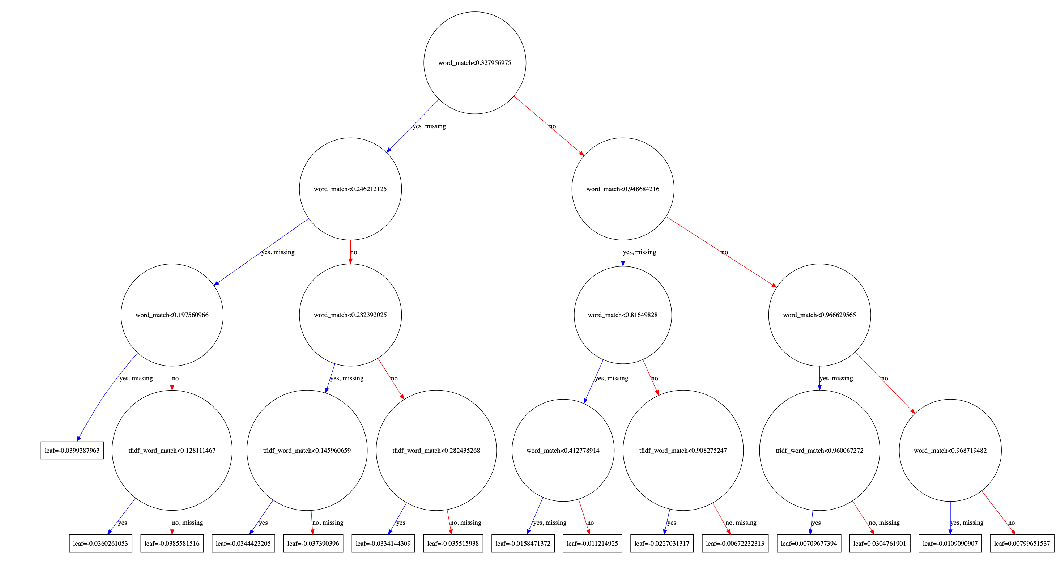

In [33]:
import matplotlib.pyplot as plt

xgb.plot_tree(bst,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

### 13. Visualize Feature Importance
Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this.

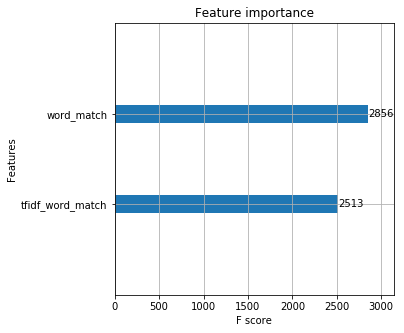

In [35]:
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

As you can see the feature word_match still has been given the highest importance score among all the features. Thus XGBoost also gives you a way to do Feature Selection. This brings us to the end of this assignment. Following are the key takeaways :
1. Feature generation using text
    - word_match
    - tf-idf
    - tf-idf_word_match
2. Data Visualisation for textual data
3. XGBoost for a predictive model
    - Visualising trees
    - Feature importance in trees